In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# For Jupyter Notebook, display plots inline.
%matplotlib inline


In [3]:
# Load the CSV data
df = pd.read_csv('data_preprocessed_with_all_sectors.csv')

# Optionally, inspect the data
df.head()


,Price,Price/Earnings,Dividend_Yield,Earnings/Share,52_Week_Low,52_Week_High,Market_Cap,EBITDA,Price/Sales,Price/Book,...,Sector_Consumer Staples,Sector_Energy,Sector_Financials,Sector_Health Care,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Telecommunication Services,Sector_Utilities
0,0.878344,-0.008454,0.280215,0.743147,0.875014,0.861718,0.986142,0.796009,0.125507,-0.035195,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.324371,0.076259,-0.489462,-0.382941,-0.349252,-0.327918,-0.425974,-0.432863,-0.108525,-0.090795,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.353727,-0.052652,0.004876,-0.643643,-0.373496,-0.390377,0.582168,0.315342,-0.061133,-0.126005,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.032340,-0.128771,0.388497,-0.095082,0.018386,-0.223349,1.457061,0.979604,0.671617,0.129711,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.343130,0.020029,-0.121474,0.294160,0.253414,0.291456,0.545135,0.300682,-0.387530,-0.043217,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
def create_windows(data, window_size, target_column='Price'):
    X = []
    y = []
    # Loop through the DataFrame to create windows
    for i in range(len(data) - window_size):
        # The window of features for 5 days (shape: (window_size, number_of_features))
        X.append(data.iloc[i:i+window_size].values)
        # The target is the value of the target_column immediately after the window
        y.append(data.iloc[i+window_size][target_column])
    return np.array(X), np.array(y)

# Define window size (5 days)
window_size = 5

# Create the windows
X, y = create_windows(df, window_size, target_column='Price')

# Print the shapes of the input and target arrays.
print("X shape:", X.shape)  # Expected shape: (num_samples, 5, num_features)
print("y shape:", y.shape)


X shape: (490, 5, 21)
y shape: (490,)


In [ ]:
# Remove target column from the features, to avoid feeding the target into the model.
features = df.drop('Price', axis=1)
target = df['Price']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 392
Testing samples: 98


In [7]:
# Define the input dimensions
n_timesteps = window_size            # 5 days per sample
n_features = X.shape[2]              # Number of features (e.g., 21 columns)

# Build the Sequential model
model = Sequential()

# Add a Conv1D layer.
# - 64 filters
# - kernel_size=2 (experiment with different sizes)
# - 'relu' activation
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_timesteps, n_features)))

# Add a MaxPooling1D layer to downsample the data
model.add(MaxPooling1D(pool_size=2))

# Add a Dropout layer for regularization
model.add(Dropout(0.5))

# Flatten the output to feed into Dense layers
model.add(Flatten())

# A fully connected layer with 50 neurons
model.add(Dense(50, activation='relu'))

# Output layer: a single neuron for regression (predicting the next day's Price)
model.add(Dense(1, activation='linear'))

# Compile the model with Adam optimizer and mean squared error loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             2752      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 64)             0         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 50)                6450      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

In [8]:
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test))


Epoch 1/50


2025-02-11 21:10:34.932284: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13/13 [==============================] - 0s 7ms/step - loss: 1.0628 - val_loss: 2.1568
Epoch 2/50
13/13 [==============================] - 0s 2ms/step - loss: 0.8744 - val_loss: 2.0723
Epoch 3/50
13/13 [==============================] - 0s 13ms/step - loss: 0.8341 - val_loss: 2.0556
Epoch 4/50
13/13 [==============================] - 0s 2ms/step - loss: 0.7383 - val_loss: 2.0551
Epoch 5/50
13/13 [==============================] - 0s 2ms/step - loss: 0.7158 - val_loss: 2.0496
Epoch 6/50
13/13 [==============================] - 0s 2ms/step - loss: 0.7070 - val_loss: 2.0774
Epoch 7/50
13/13 [==============================] - 0s 2ms/step - loss: 0.6560 - val_loss: 2.0850
Epoch 8/50
13/13 [==============================] - 0s 2ms/step - loss: 0.6749 - val_loss: 2.0868
Epoch 9/50
13/13 [==============================] - 0s 2ms/step - loss: 0.6578 - val_loss: 2.0753
Epoch 10/50
13/13 [==============================] - 0s 2ms/step - loss: 0.6615 - val_loss: 2.0755
Epoch 11/50
13/13 [==========

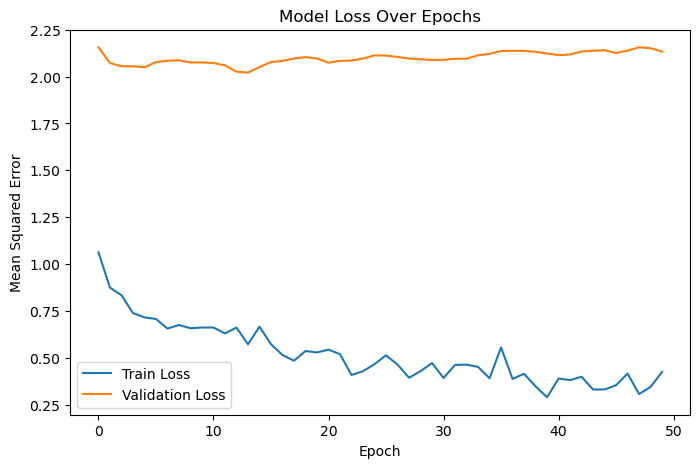

In [9]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [10]:
# Predict on the test set
y_pred = model.predict(X_test)

# Print out the first few predictions compared to actual values
for i in range(5):
    print(f"Predicted: {y_pred[i][0]:.4f}, Actual: {y_test[i]:.4f}")

4/4 [==============================] - 0s 772us/step
Predicted: -0.0600, Actual: -0.4158
Predicted: -0.2187, Actual: -0.2941
Predicted: -0.1571, Actual: -0.1744
Predicted: -0.1320, Actual: -0.6307
Predicted: -0.1855, Actual: 0.2285


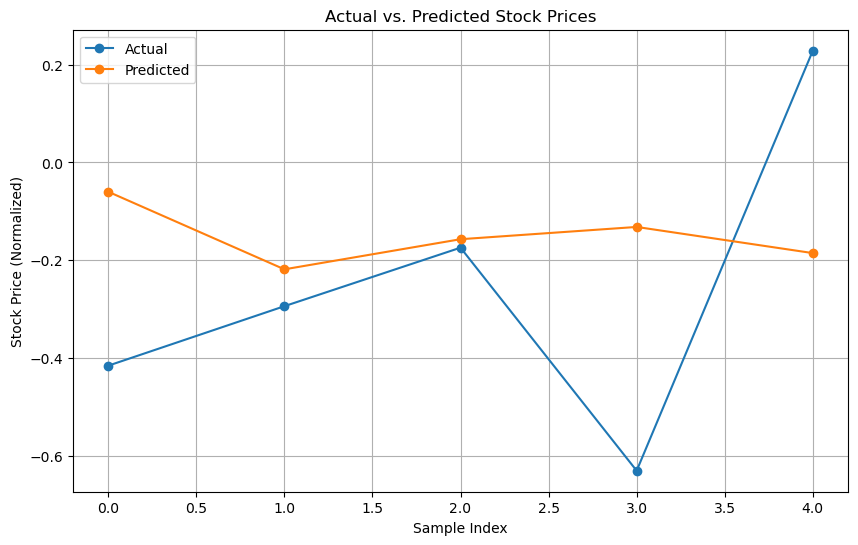

In [12]:
# Your data
actual = [-0.4158, -0.2941, -0.1744, -0.6307, 0.2285]
predicted = [-0.0600, -0.2187, -0.1571, -0.1320, -0.1855]


plt.figure(figsize=(10, 6))
plt.plot(actual, marker='o', label='Actual')
plt.plot(predicted, marker='o', label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price (Normalized)')
plt.title('Actual vs. Predicted Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on the full test set
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluation Metrics on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


4/4 [==============================] - 0s 977us/step
Evaluation Metrics on Test Set:
Mean Squared Error (MSE): 2.1343
Root Mean Squared Error (RMSE): 1.4609
Mean Absolute Error (MAE): 0.5894
R² Score: -0.0407
